## Planteamiento del problema

La primera pregunta que queremos responder es
**¿El ruido estructurado en las etiquetas afecta al rendimiento?**

En este experimento, consideraremos el siguiente escenario:
- Tenemos $n$ imágenes con etiquetas limpias.
- Por cada imagen con etiquetas limpias, introducimos $\alpha$ imágenes con etiquetas ruidosas (es decir, su etiqueta es aleatoria). Por tanto, añadimos $\alpha n$ imágenes.
- En total, acabamos con $\alpha n + n = (\alpha+1)n $ imágenes

En este experimento, fijamos $\alpha=20$ y $n = 60000$.

Las arquitecturas y *dataset* que utilizaremos en este experimento serán:
- Trabajaremos con el conjunto de datos MNIST.
- Trabarejemos con el modelo ResNet18.
- Utilizaremos ruido estructurado, en el que la etiqueta ruidosa se asigna aleatoriamente entre las clases posibles, con diferente probabilidad para cada clase (la probabilidad se determinará a partir de la confusión de clases).

Realizaremos el entrenamiento con el conjunto de datos ruidoso y evaluaremos su rendimiento en un conjunto de test limpio (sin ruido).

## Instalación de fastai

In [1]:
!pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [2]:
from fastai.vision.all import *
import fastai
import numpy

print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("FastAI:", fastai.__version__)
print("NumPy:", numpy.__version__)

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch: 2.6.0+cu124
CUDA disponible: True
FastAI: 2.8.2
NumPy: 2.0.2


## Carga del *dataset* MNIST

Descargamos el *dataset* MNIST:

In [3]:
# We get the MNIST dataset
path = untar_data(URLs.MNIST,force_download=True)

In [4]:
# The MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the test set.
print(path)
print(path.ls())
print((path/'training').ls())
print((path/'testing').ls())
train_classes = (path/'training').ls()
test_classes = (path/'testing').ls()

/root/.fastai/data/mnist_png
[Path('/root/.fastai/data/mnist_png/training'), Path('/root/.fastai/data/mnist_png/testing')]
[Path('/root/.fastai/data/mnist_png/training/6'), Path('/root/.fastai/data/mnist_png/training/8'), Path('/root/.fastai/data/mnist_png/training/4'), Path('/root/.fastai/data/mnist_png/training/9'), Path('/root/.fastai/data/mnist_png/training/2'), Path('/root/.fastai/data/mnist_png/training/3'), Path('/root/.fastai/data/mnist_png/training/0'), Path('/root/.fastai/data/mnist_png/training/5'), Path('/root/.fastai/data/mnist_png/training/1'), Path('/root/.fastai/data/mnist_png/training/7')]
[Path('/root/.fastai/data/mnist_png/testing/6'), Path('/root/.fastai/data/mnist_png/testing/8'), Path('/root/.fastai/data/mnist_png/testing/4'), Path('/root/.fastai/data/mnist_png/testing/9'), Path('/root/.fastai/data/mnist_png/testing/2'), Path('/root/.fastai/data/mnist_png/testing/3'), Path('/root/.fastai/data/mnist_png/testing/0'), Path('/root/.fastai/data/mnist_png/testing/5'), P

Comprobamos que efectivamente disponemos de $60000$ ejemplos de entrenamiento y $10000$ de *test*, que el tamaño de las imágenes es $28\times 28$ y que el número de clases es $10$ ($0$-$9$).

In [5]:
from cv2 import imread

n_training = np.sum([len(class_files.ls()) for class_files in train_classes])
n_test = np.sum([len(class_files.ls()) for class_files in test_classes])

img = imread(path/'training'/'0'/'1.png',0)
width, height = img.shape
num_channels = 1
num_classes = len(train_classes)

print(f"Número de imágenes de entrenamiento: {n_training}")
print(f"Número de imágenes de test: {n_test}")
print(f"Tamaño de las imágenes: {width}x{height}x{num_channels}")
print(f"Número de clases: {num_classes}")

Número de imágenes de entrenamiento: 60000
Número de imágenes de test: 10000
Tamaño de las imágenes: 28x28x1
Número de clases: 10


Seleccionamos un valor para $\alpha$ y fijamos la semilla aleatoria con el fin de garantizar la reproducibilidad en la mayor medida posible.

In [6]:
alpha = 20
random.seed(42)

### Cálculo de las clases más confundidas

Seleccionamos todas las imágenes del entrenamiento (limpias) y creamos un *datablock*:

In [7]:
selected_images = get_image_files(path/'training')
labels = [parent_label(f) for f in selected_images]
len(selected_images)

60000

In [8]:
valid_part = 0.2
batch_size = 128

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda _: range(0,len(selected_images)),
    get_x=lambda x: selected_images[x],
    get_y=lambda x: labels[x],
    splitter=RandomSplitter(valid_pct=valid_part, seed=42)
)

dls = dblock.dataloaders(path/'training', bs=batch_size)

#### Creación del modelo

Creamos el modelo ResNet18 y lo entrenamos durante $3$ épocas en el conjunto de entrenamiento limpio para finalmente calcular la matriz de confusión y determinar qué clases se confunden en mayor medida.

In [9]:
learning_rate = 0.1
num_epochs = 3

In [10]:
from torch.optim import Adadelta

# Crear el MLP con 2 capas ocultas
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

model = models.resnet18

# pretrained = False, queremos entrenar todos los pesos de la red
learn = vision_learner(dls,
                       model,
                       pretrained = False,
                       n_in=num_channels,
                       metrics=[accuracy, F1Score(average='weighted')],
                       opt_func=opt_func,
                       loss_func=CrossEntropyLossFlat(),
                       cbs=[EarlyStoppingCallback(monitor='valid_loss')])

#### Entrenamiento con datos no ruidosos

In [11]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.148853,0.129598,0.960917,0.960975,00:38
1,0.089460,0.091891,0.973083,0.972855,00:35
2,0.047250,0.056872,0.984750,0.984735,00:29


#### Matriz de confusión del modelo

In [12]:
interp = ClassificationInterpretation.from_learner(learn, ds_idx=1)
cm = interp.confusion_matrix()

In [13]:
df_cm = pd.DataFrame(cm, index=learn.dls.vocab, columns=learn.dls.vocab)
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
df_cm

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,1226,0,0,0,0,0,5,0,2,0
1,0,1334,2,3,1,0,1,2,2,1
2,1,2,1216,1,1,0,0,2,5,0
3,0,0,3,1197,0,16,0,4,7,3
4,0,0,2,0,1126,0,6,2,1,3
5,0,0,1,1,2,1084,4,1,5,2
6,3,0,0,1,1,2,1170,0,1,0
7,0,5,1,1,1,0,0,1243,2,3
8,1,1,4,3,2,2,2,1,1113,7


Creamos dos diccionarios, uno que almacena las clases más confundidas de forma ordenada. En ambos casos, dejamos la clase real al final.

In [14]:
# Para cada clase (fila), ordenamos los errores por número de errores (valor alto)
# y en caso de empate por clase menor
most_confused_lists = {}
least_confused_lists = {}

for true_class in range(10):
    errors = []
    for pred_class in range(10):
        if pred_class == true_class:
            continue
        errors.append((cm[true_class, pred_class], pred_class))

    # Ordenamos por: más errores y, si hay empate, clase más pequeña
    sorted_errors = sorted(errors, key=lambda x: (-x[0], x[1]))
    most_confused = [pred for _, pred in sorted_errors]
    most_confused_lists[true_class] = most_confused
    least_confused_lists[true_class] = most_confused[::-1]
    most_confused_lists[true_class].append(true_class)
    least_confused_lists[true_class].append(true_class)

# Mostramos las listas
print('Clases más confundidas:')
for k, v in most_confused_lists.items():
    print(f"{k} --> {v}")
print()

print('Clases menos confundidas:')
for k, v in least_confused_lists.items():
    print(f"{k} --> {v}")

Clases más confundidas:
0 --> [6, 8, 1, 2, 3, 4, 5, 7, 9, 0]
1 --> [3, 2, 7, 8, 4, 6, 9, 0, 5, 1]
2 --> [8, 1, 7, 0, 3, 4, 5, 6, 9, 2]
3 --> [5, 8, 7, 2, 9, 0, 1, 4, 6, 3]
4 --> [6, 9, 2, 7, 8, 0, 1, 3, 5, 4]
5 --> [8, 6, 4, 9, 2, 3, 7, 0, 1, 5]
6 --> [0, 5, 3, 4, 8, 1, 2, 7, 9, 6]
7 --> [1, 9, 8, 2, 3, 4, 0, 5, 6, 7]
8 --> [9, 2, 3, 4, 5, 6, 0, 1, 7, 8]
9 --> [4, 5, 7, 0, 8, 1, 2, 3, 6, 9]

Clases menos confundidas:
0 --> [9, 7, 5, 4, 3, 2, 1, 8, 6, 0]
1 --> [5, 0, 9, 6, 4, 8, 7, 2, 3, 1]
2 --> [9, 6, 5, 4, 3, 0, 7, 1, 8, 2]
3 --> [6, 4, 1, 0, 9, 2, 7, 8, 5, 3]
4 --> [5, 3, 1, 0, 8, 7, 2, 9, 6, 4]
5 --> [1, 0, 7, 3, 2, 9, 4, 6, 8, 5]
6 --> [9, 7, 2, 1, 8, 4, 3, 5, 0, 6]
7 --> [6, 5, 0, 4, 3, 2, 8, 9, 1, 7]
8 --> [7, 1, 0, 6, 5, 4, 3, 2, 9, 8]
9 --> [6, 3, 2, 1, 8, 0, 7, 5, 4, 9]


### Selección de las imágenes

Una vez que ya tenemos las clases más confundidas, seleccionamos todas las imágenes del entrenamiento y las repetimos $20$ veces ($\alpha=20$):

In [15]:
def repeat_images(images, alpha):
    """Devuelve una lista con cada imagen repetida alpha veces."""
    return L(img for img in images for _ in range(alpha+1))

In [16]:
selected_images = get_image_files(path/'training')
selected_images = repeat_images(selected_images, alpha)

In [17]:
len(selected_images)

1260000

### Cálculo de las probabilidades de cada clase

Decidimos ahora el grado de estructura $\delta \in [0,1]$ y ajustamos las probabilidades de las clases.

Sea $m$ el número de imágenes etiquetadas con una clase concreta $c$. Cada una de esas imágenes, la repetimos $\alpha$ veces. Por tanto, en total, tendremos $m(\alpha+1)$ imágenes con clase real $c$. De esas imágenes, $m\alpha$ imágenes se etiquetan con una clase aleatoria.

Por tanto, la proporción de imágenes limpias respecto al total será:
$$
\epsilon = \frac{m}{m(\alpha+1)} = \frac{1}{1+\alpha}.
$$

En el caso del ruido uniforme, se estima que cada clase será asignada al $10\%$ de las imágenes, por lo que la proporción de imágenes ruidosas asignadas a una clase será:
$$
\frac{1}{10}\frac{m\alpha}{m(\alpha+1)} = \frac{1}{10}\frac{\alpha}{\alpha+1}.
$$

En el caso del ruido estructurado, mantendremos esta proporción únicamente para la clase correcta, es decir, la clase $c$.

Sin embargo, el resto de clases se ordenarán según un criterio (en nuestro caso, mayor o menor confusión). La clases que sean anteriores en este orden, tendrán una probabilidad mayor de ser asignadas a la imagen ruidosa.

La primera clase en este orden tendrá una proporción:
$$
\frac{1}{10}\frac{\alpha}{\alpha+1} + \delta \epsilon.
$$

Para calcular la probabilidad que se le deberá asignar a esta clase, calculamos la proporción respecto al total de imágenes ruidosas:
$$
\frac{\left(\frac{1}{10}\frac{\alpha}{\alpha+1} + \delta \epsilon\right)m(\alpha+1)}{m\alpha} = \frac{1}{10} + \frac{\delta}{\alpha}.
$$


El resto de probabilidades se asignan linealmente. Es decir, calculamos una cantidad $x$ que verifique:
$$
\sum_{i=1}^8 \left( \frac{1}{10} + \frac{\delta}{\alpha} - i\cdot x \right) + \underbrace{\frac{1}{10}}_{\text{clase } c} = 1
$$

Concluimos que
$$
x = \frac{1}{4} \frac{\delta}{\alpha},
$$

por lo que ya tenemos todas las probabilidades que queríamos.

Nótese que para que estas probabilidades se encuentren entre $0$ y $1$ para $\delta \in [0,1]$ se debe tener $\alpha \geq 10$.


In [18]:
delta = 0.25

In [19]:
prob_correct = 1/num_classes

prob_most_likely = prob_correct + delta / alpha
probs = np.array([prob_most_likely])

for i in range(2,10):
  probs = np.append(probs,probs[i-2]-0.25*delta/alpha)

probs = np.append(probs,prob_correct)
probs

array([0.1125  , 0.109375, 0.10625 , 0.103125, 0.1     , 0.096875,
       0.09375 , 0.090625, 0.0875  , 0.1     ])

Seleccionamos los hiperparámetros que utilizaremos en los siguientes experimentos:

In [20]:
early_stopping_patience = 3
num_epochs = 4

Seleccionamos a continuación las etiquetas ruidosas que utilizaremos:

### Selección de las etiquetas con el criterio mayor confusión

Creamos una función que selecciona las imágenes del conjunto de entrenamiento, y les asigna una etiqueta de forma aleatoria (utilizando las probabilidades anteriores):

In [23]:
def get_labels_most_confused(images):
  i = 0
  labels = []

  while(i<len(images)):
    actual_label = parent_label(images[i])
    labels.append(actual_label)

    for j in range(alpha):
      int_label = int(actual_label)
      label= str(np.random.choice(most_confused_lists[int_label], p=probs))
      labels.append(label)

    i += 1+alpha

  return labels

In [24]:
labels = get_labels_most_confused(selected_images)

Combinamos todo en un *datablock* (que es la forma que tiene fastai de gestionar los datos de entrada):

In [25]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda _: range(0,len(selected_images)),
    get_x=lambda x: selected_images[x],
    get_y=lambda x: labels[x],
    splitter=RandomSplitter(valid_pct=valid_part, seed=42)
)

dls = dblock.dataloaders(path/'training', bs=batch_size)

Mostramos algunos ejemplos de nuestros datos de entrada:

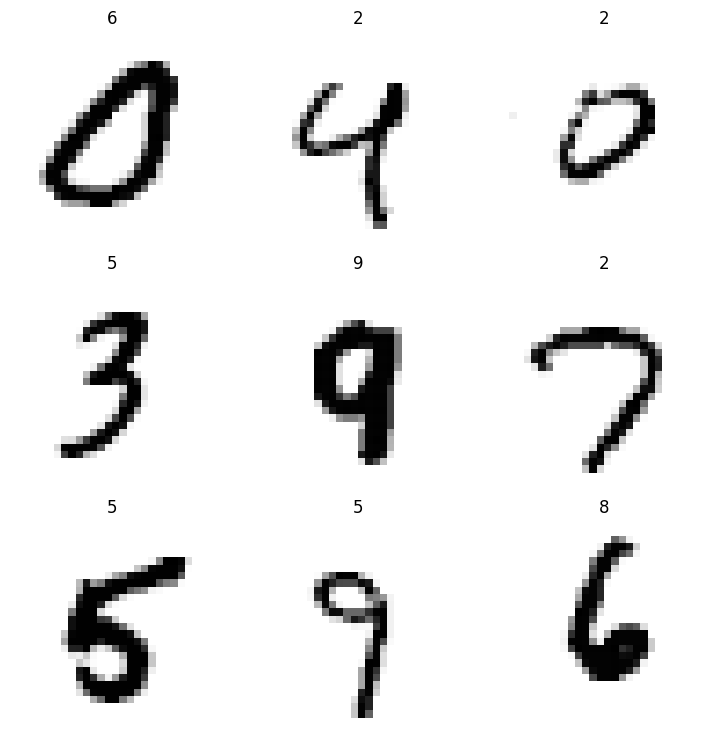

In [26]:
dls.show_batch(max_n=9)

#### Entrenamiento del modelo

Seleccionamos distintos hiperparámetros:

In [27]:
learning_rate = 0.1

In [28]:
# Crear el aprendiz (learner)
learn = vision_learner(dls,
                       model,
                       pretrained = False,
                       n_in=num_channels,
                       metrics=[accuracy, F1Score(average='weighted')],
                       opt_func=opt_func,
                       loss_func=CrossEntropyLossFlat(),
                       cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=early_stopping_patience)])

In [29]:
learn.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 14 x 14  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 7 x 7    
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                       

In [31]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.373773,2.350629,0.134337,0.132903,09:59
1,2.327613,2.302879,0.137052,0.136265,09:57
2,2.305949,2.306907,0.138917,0.138533,09:54
3,2.301512,2.301691,0.139401,0.139213,09:53


#### Rendimiento en el conjunto de *test*

Medimos ahora el rendimiento utilizando el conjunto de test:

In [32]:
from sklearn.metrics import accuracy_score, f1_score

def accuracy_f1_test(test_path, learner):
  files_test = get_image_files(test_path)
  dls_test = learner.dls.test_dl(files_test, with_labels = False)
  preds = learner.get_preds(dl = dls_test, with_decoded = True)

  preds_labels = [learner.dls.vocab[i] for i in preds[2]]
  targs = [parent_label(f) for f in files_test]

  test_accuracy = accuracy_score(preds_labels, targs)
  test_f1 = f1_score(preds_labels, targs, average='weighted')

  print(f"Accuracy en test: {test_accuracy:.2f}")
  print(f"F1 en test: {test_f1:.2f}")

In [33]:
accuracy_f1_test(path/'testing', learn)

Accuracy en test: 0.96
F1 en test: 0.96


### Selección de las etiquetas con el criterio menor confusión

Creamos una función que selecciona las imágenes del conjunto de entrenamiento, y les asigna una etiqueta de forma aleatoria (utilizando las probabilidades anteriores):

In [34]:
def get_labels_least_confused(images):
  i = 0
  labels = []

  while(i<len(images)):
    actual_label = parent_label(images[i])
    labels.append(actual_label)

    for j in range(alpha):
      int_label = int(actual_label)
      label= str(np.random.choice(least_confused_lists[int_label], p=probs))
      labels.append(label)

    i += 1+alpha

  return labels

In [35]:
labels = get_labels_least_confused(selected_images)

Combinamos todo en un *datablock* (que es la forma que tiene fastai de gestionar los datos de entrada):

In [36]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda _: range(0,len(selected_images)),
    get_x=lambda x: selected_images[x],
    get_y=lambda x: labels[x],
    splitter=RandomSplitter(valid_pct=valid_part, seed=42)
)

dls = dblock.dataloaders(path/'training', bs=batch_size)

Mostramos algunos ejemplos de nuestros datos de entrada:

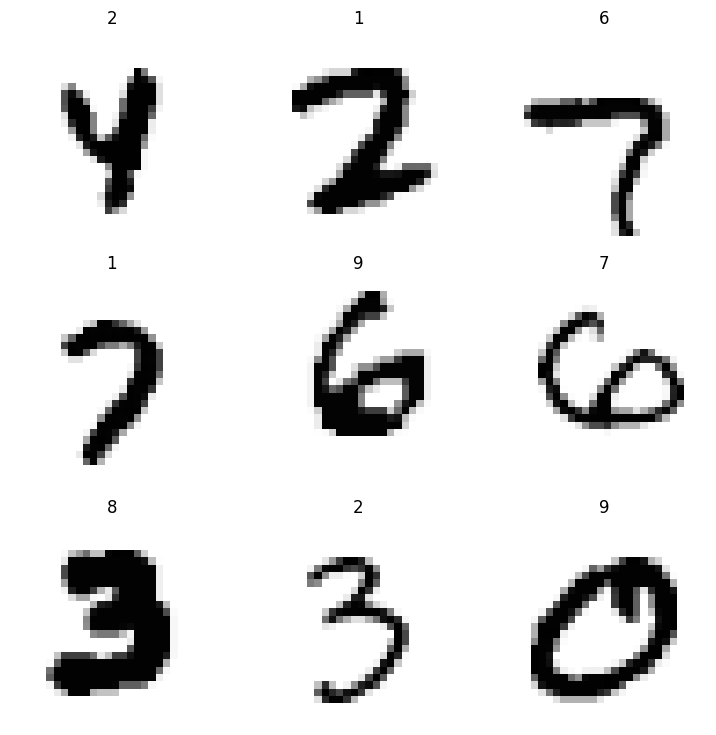

In [37]:
dls.show_batch(max_n=9)

#### Entrenamiento del modelo

Seleccionamos distintos hiperparámetros:

In [38]:
learning_rate = 0.1

In [39]:
# Crear el aprendiz (learner)
learn = vision_learner(dls,
                       model,
                       pretrained = False,
                       n_in=num_channels,
                       metrics=[accuracy, F1Score(average='weighted')],
                       opt_func=opt_func,
                       loss_func=CrossEntropyLossFlat(),
                       cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=early_stopping_patience)])

In [40]:
learn.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 14 x 14  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 7 x 7    
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                       

In [41]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.384630,2.317736,0.134766,0.133853,09:44
1,2.342368,2.309097,0.139333,0.138943,09:46
2,2.310841,2.334020,0.140762,0.140631,09:43
3,2.301830,2.331001,0.141234,0.141041,09:50


#### Rendimiento en el conjunto de *test*

Medimos ahora el rendimiento utilizando el conjunto de test:

In [42]:
accuracy_f1_test(path/'testing', learn)

Accuracy en test: 0.94
F1 en test: 0.94


# Gráfica de los resultados obtenidos

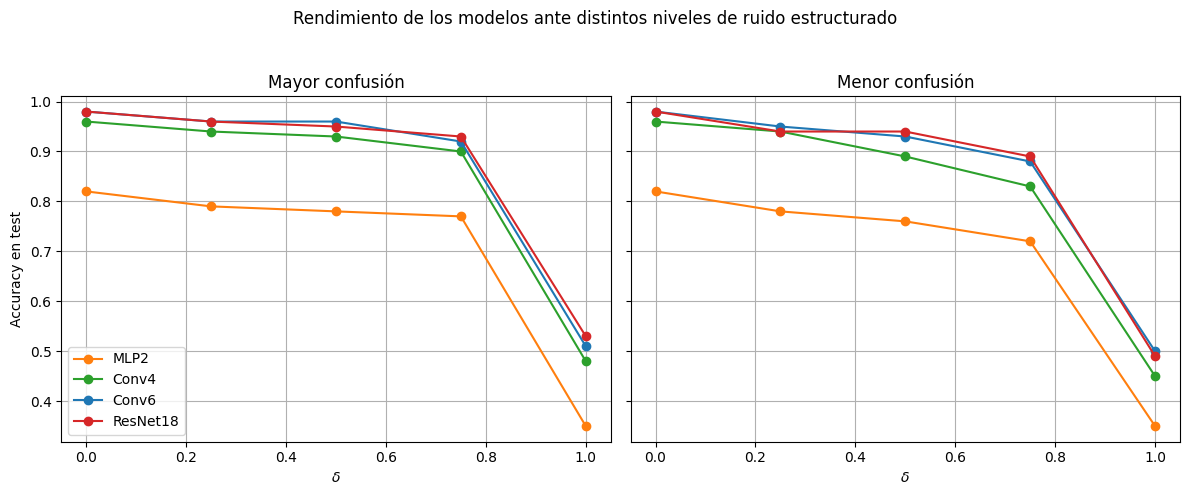

In [ ]:
import matplotlib.pyplot as plt

# Valores de delta
delta = [0, 0.25, 0.5, 0.75, 1.0]

# Datos de test accuracy
mayor_conf = {
    'MLP2':      [0.82, 0.79, 0.78, 0.77, 0.35],
    'Conv4':     [0.96, 0.94, 0.93, 0.90, 0.48],
    'Conv6':     [0.98, 0.96, 0.96, 0.92, 0.51],
    'ResNet18':  [0.98, 0.96, 0.95, 0.93, 0.53]
}

menor_conf = {
    'MLP2':      [0.82, 0.78, 0.76, 0.72, 0.35],
    'Conv4':     [0.96, 0.94, 0.89, 0.83, 0.45],
    'Conv6':     [0.98, 0.95, 0.93, 0.88, 0.50],
    'ResNet18':  [0.98, 0.94, 0.94, 0.89, 0.49]
}

# Crear subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Colores consistentes para los modelos
colors = {
    'MLP2': 'tab:orange',
    'Conv4': 'tab:green',
    'Conv6': 'tab:blue',
    'ResNet18': 'tab:red'
}

# Primer subplot: mayor confusión
axs[0].set_title("Mayor confusión")
for model, acc in mayor_conf.items():
    axs[0].plot(delta, acc, marker='o', label=model, color=colors[model])
axs[0].set_xlabel(r"$\delta$")
axs[0].set_ylabel("Accuracy en test")
axs[0].grid(True)
axs[0].legend()

# Segundo subplot: menor confusión
axs[1].set_title("Menor confusión")
for model, acc in menor_conf.items():
    axs[1].plot(delta, acc, marker='o', label=model, color=colors[model])
axs[1].set_xlabel(r"$\delta$")
axs[1].grid(True)

# Ajuste final
plt.suptitle("Rendimiento de los modelos ante distintos niveles de ruido estructurado")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()